In [180]:
# Importing the libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

import glob
import os

from astropy.io import fits

from scipy import stats
from scipy import ndimage
from scipy.ndimage import label
from scipy.optimize import curve_fit
from scipy.signal import correlate2d
from scipy.ndimage import shift

from uncertainties import *
from uncertainties.unumpy import *
from uncertainties.umath import *

In [181]:
# Loading images
image = fits.getdata("data/IMG_1505.fits")
header = fits.getheader("data/IMG_1505.fits")

exposure_time = header['EXPTIME']
print(f"Exposure time: {exposure_time} seconds")

Exposure time: 16.0 seconds


In [182]:
# Background subtraction
x1, y1 = 4204, 462  # Bottom-left corner
x2, y2 = 5286, 3572  # Top-right corner

background_region = image[y1:x1, y2:x2]
background_mean = np.mean(background_region)

sigma_bg = np.std(background_region)

image_clean = image - background_mean

print("Background mean: ", background_mean)
print("Background std: ", sigma_bg)

Background mean:  1335.4140108388156
Background std:  257.7728199474531


In [183]:
x_min, x_max = 3680, 3930 
y_min, y_max = 866, 1116 

roi = image_clean[y_min:y_max, x_min:x_max]

local_max_index = np.unravel_index(np.argmax(roi), roi.shape)

comet_center = (local_max_index[0] + y_min, local_max_index[1] + x_min)

print(f"Comet nucleus center: {comet_center}")

Comet nucleus center: (np.int64(973), np.int64(3819))


In [184]:
# Resolution
resolution = 11.1 # arcsec/pixel

rows, cols = np.indices(image_clean.shape)

distances_px = np.sqrt((rows - comet_center[0])**2 + (cols - comet_center[1])**2)

distances_arcsec = distances_px * resolution

In [185]:
# Apparent magnitudes of the calibration stars
m_star1 = 5.2
m_star2 = 3.7
m_star3 = 2.6

m_list = [m_star1, m_star2, m_star3]

# Coordinates of the calibration stars
star1_coords = (2874, 2226)  
star2_coords = (3249, 2848)
star3_coords = (3439, 3560) 

star_annulus_radius = 30  

def calculate_flux(data, center, radius):
    distances = np.sqrt((rows - center[0])**2 + (cols - center[1])**2) * resolution
    annulus_mask = distances <= radius * resolution
    flux = np.sum(data[annulus_mask]) /(exposure_time * np.pi * radius**2)
    return flux

# Measure fluxes for the calibration stars
F_star1 = calculate_flux(image_clean, star1_coords, star_annulus_radius)
F_star2 = calculate_flux(image_clean, star2_coords, star_annulus_radius)
F_star3 = calculate_flux(image_clean, star3_coords, star_annulus_radius)

F_list = [F_star1, F_star2, F_star3]

In [219]:
# Calculate comet brightness in mag 

F_comet = calculate_flux(image_clean, comet_center, 50)

mag_comet_lsit = []
for F_star, m_star in zip(F_list, m_list):
    mag_comet = m_star - 2.5 * np.log10(F_comet / F_star)
    mag_comet_lsit.append(mag_comet)

mag_comet = np.mean(mag_comet_lsit)
mag_comet_err = np.std(mag_comet_lsit) / np.sqrt(3)

print(f"Comet brightness: {mag_comet} ± {mag_comet_err}")

Comet brightness: 2.0901504039787366 ± 0.850904203318689


In [187]:
# Calculating surface brightness 
radii = np.arange(resolution, 50 * resolution, resolution)

surface_brightness = []
surface_brightness_err = []

surface_brightness_counts = []
surface_brightness_counts_err = []

for radius in radii:
    inner_radius = radius - resolution
    outer_radius = radius 

    annulus_mask = np.logical_and(
        distances_arcsec >= inner_radius,
        distances_arcsec < outer_radius
    )

    # in mag/arcsec^2
    F_annulus = np.sum(image_clean[annulus_mask]) / (exposure_time * np.pi * (outer_radius**2 - inner_radius**2))

    m_calib = []
    for i in range(3):
        m_star = m_list[i]
        F_star = F_list[i]

        m = m_star - 2.5 * np.log10(F_annulus / F_star)
        m_calib.append(m)
    
    surface_brightness.append(np.mean(m_calib))
    surface_brightness_err.append((np.std(m_calib) / np.sqrt(3)))

    # in counts/arcsec^2
    annulus_intensity = np.mean(image_clean[annulus_mask])
    annulus_intensity_err = np.std(image_clean[annulus_mask])
    surface_brightness_counts.append(np.log10(annulus_intensity))
    surface_brightness_counts_err.append(annulus_intensity_err / annulus_intensity)

radii = np.log10(radii)

In [209]:
def linear_func(x, m, c):
    return m * x + c

# Linear regression of SBP 
fit_limit = 5

popt, pcov = curve_fit(linear_func, radii[fit_limit:], surface_brightness[fit_limit:], sigma=surface_brightness_err[fit_limit:])

slope, intercept = popt
std_err = np.sqrt(np.diag(pcov))
std_err_comb = np.sqrt(std_err[0]**2 + std_err[1]**2)

print(f"Slope: {slope}, Intercept: {intercept}, std_err: {std_err_comb}")

# Linear regression of SBP in counts
popt_counts, pcov_counts = curve_fit(linear_func, radii[fit_limit:], surface_brightness_counts[fit_limit:], sigma=surface_brightness_counts_err[fit_limit:])

slope_counts, intercept_counts = popt_counts
std_err_counts = np.sqrt(np.diag(pcov_counts))
std_err_comb_counts = np.sqrt(std_err_counts[0]**2 + std_err_counts[1]**2)

print(f"\nSlope (counts): {slope_counts}, Intercept: {intercept_counts}, std_err: {std_err_comb_counts}")

Slope: 3.259322318069394, Intercept: -0.7148490295934167, std_err: 0.17053944904211848

Slope (counts): -1.1238262787758881, Intercept: 6.371462385675422, std_err: 0.07398193600138021


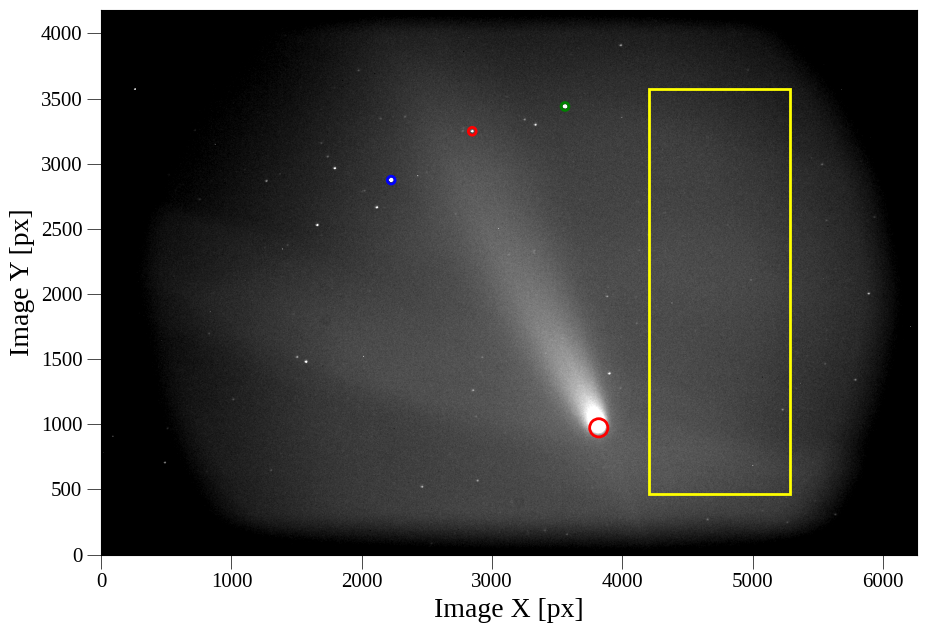

In [210]:
plt.rc("font", size=10)
plt.rcParams['font.family'] = 'Liberation Serif'
vmin = 969
vmax = 2380

fig, ax = plt.subplots(figsize=(10, 6.5))

ax.set_xlabel('Image X [px]')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Image Y [px]')
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
plt.tight_layout()  

circle_star1 = plt.Circle((star1_coords[1], star1_coords[0]), radius=30, color='blue', fill=False, linewidth=2, label='Star 1 radius')
ax.add_patch(circle_star1)
circle_star2 = plt.Circle((star2_coords[1], star2_coords[0]), radius=30, color='red', fill=False, linewidth=2, label='Star 2 radius')
ax.add_patch(circle_star2)
circle_star3 = plt.Circle((star3_coords[1], star3_coords[0]), radius=30, color='green', fill=False, linewidth=2, label='Star 3 radius')
ax.add_patch(circle_star3)

circle = plt.Circle((comet_center[1], comet_center[0]), 70, color='red', fill=False, linewidth=2, label='35px (388.5 arcsec) radius')
ax.add_patch(circle)

rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='yellow', facecolor='none', label='Background region')
ax.add_patch(rect)

ax.imshow(image, cmap="gray", origin="lower", vmin=vmin, vmax=vmax)

# ax.legend(loc='lower left', fontsize=15)

plt.savefig('images/comet.png')

plt.show()

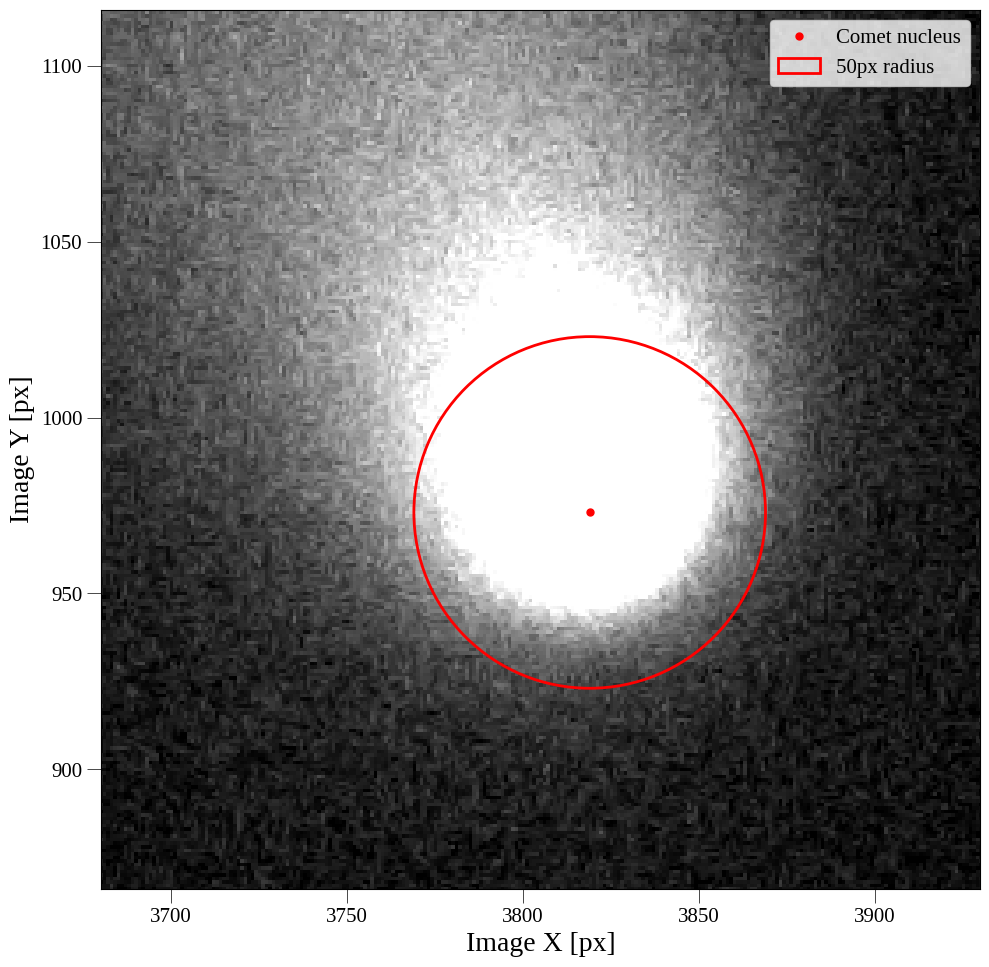

In [211]:
vmin = 50
vmax = 2000

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlabel('Image X [px]')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Image Y [px]')
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
ax.set_xlim(3680,3930)
ax.set_ylim(866,1116)
plt.tight_layout()  

ax.imshow(image_clean, cmap="gray", origin="lower", vmin=vmin, vmax=vmax)

ax.plot(comet_center[1], comet_center[0], 'ro', markersize=5, label="Comet nucleus")

circle = plt.Circle((comet_center[1], comet_center[0]), 50, color='red', fill=False, linewidth=2, label='50px radius')
ax.add_patch(circle)

ax.legend(loc='upper right', fontsize=15)

plt.savefig('images/comet_clean.png')

plt.show()

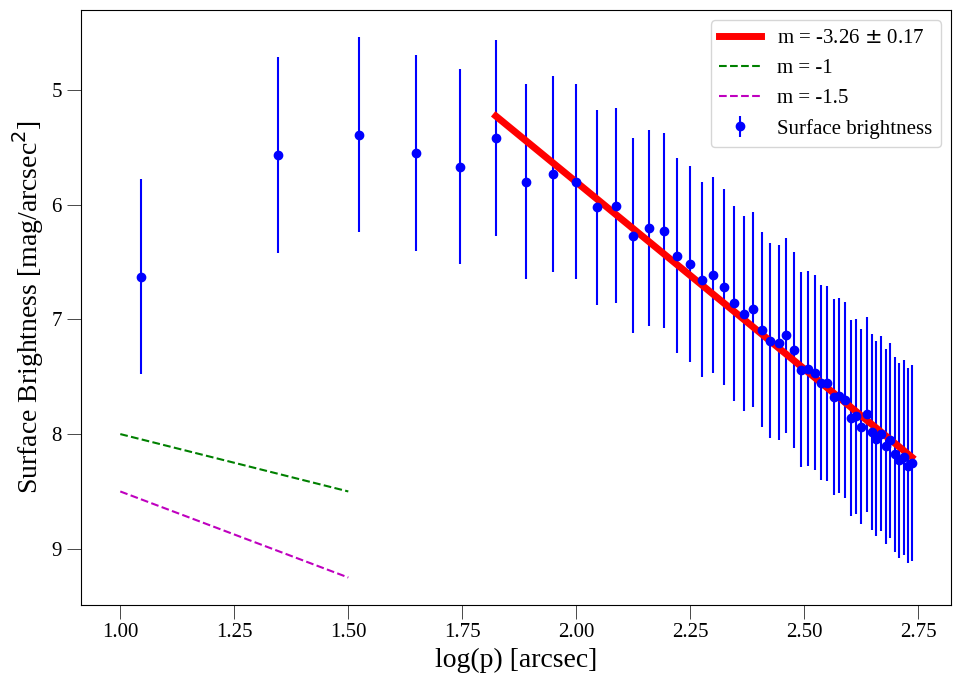

In [218]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.set_xlabel('log(p) [arcsec]')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel(r'Surface Brightness [mag/arcsec$^2$]')
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
ax.invert_yaxis()
plt.tight_layout()  

ax.errorbar(radii, surface_brightness, yerr=surface_brightness_err, fmt='o', color='blue', label="Surface brightness")

ax.plot(radii[fit_limit:], slope*radii[fit_limit:] + intercept, color='red', linewidth=5, label=r'm = -{:.2f} $\pm$ {:.2f}'.format(slope, std_err_comb))

# Plotting reference lines
x_vals = np.array([1, 1.5])
ax.plot(x_vals, 1 * x_vals + 7, 'g--', label='m = -1')
ax.plot(x_vals, 1.5 * x_vals + 7, 'm--', label='m = -1.5')

ax.legend(loc='upper right', fontsize=15)

plt.savefig('images/sbp.png')

plt.show()

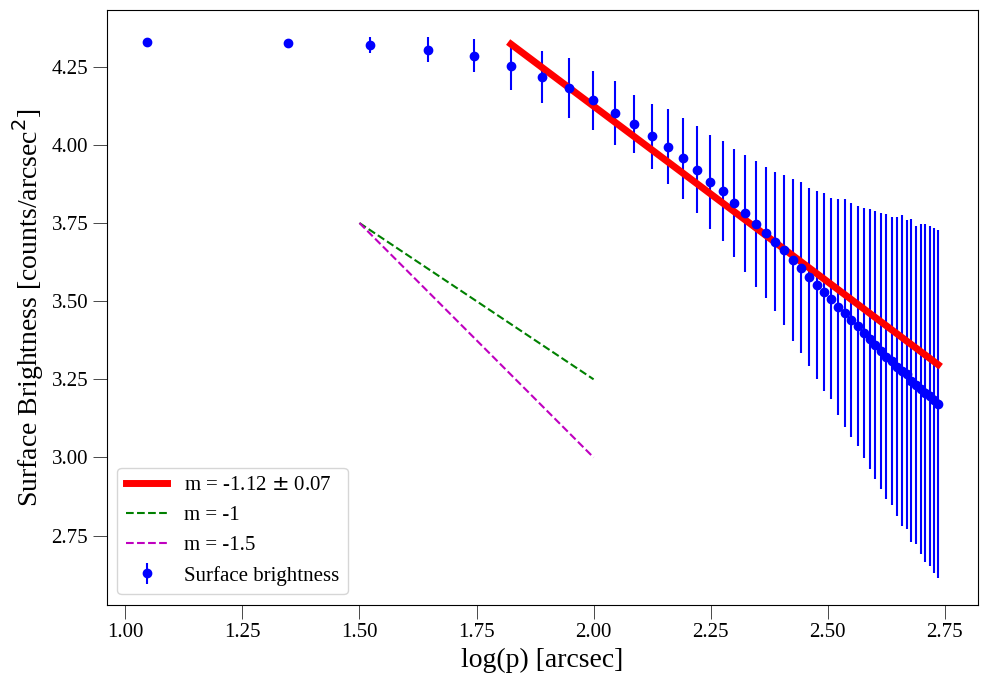

In [213]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.set_xlabel('log(p) [arcsec]')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel(r'Surface Brightness [counts/arcsec$^2$]')
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
# ax.invert_yaxis()
plt.tight_layout()  

ax.errorbar(radii, surface_brightness_counts, yerr=surface_brightness_counts_err, fmt='o', color='blue', label="Surface brightness")

ax.plot(radii[fit_limit:], slope_counts*radii[fit_limit:] + intercept_counts, color='red', linewidth=5, label=r'm = {:.2f} $\pm$ {:.2f}'.format(slope_counts, std_err_comb_counts))

# Plotting reference lines
x_vals = np.array([1.5, 2])
ax.plot(x_vals, -1 * x_vals + 5.25, 'g--', label='m = -1')
ax.plot(x_vals, -1.5 * x_vals + 6, 'm--', label='m = -1.5')

ax.legend(loc='lower left', fontsize=15)

plt.savefig('images/sbp_counts.png')

plt.show()

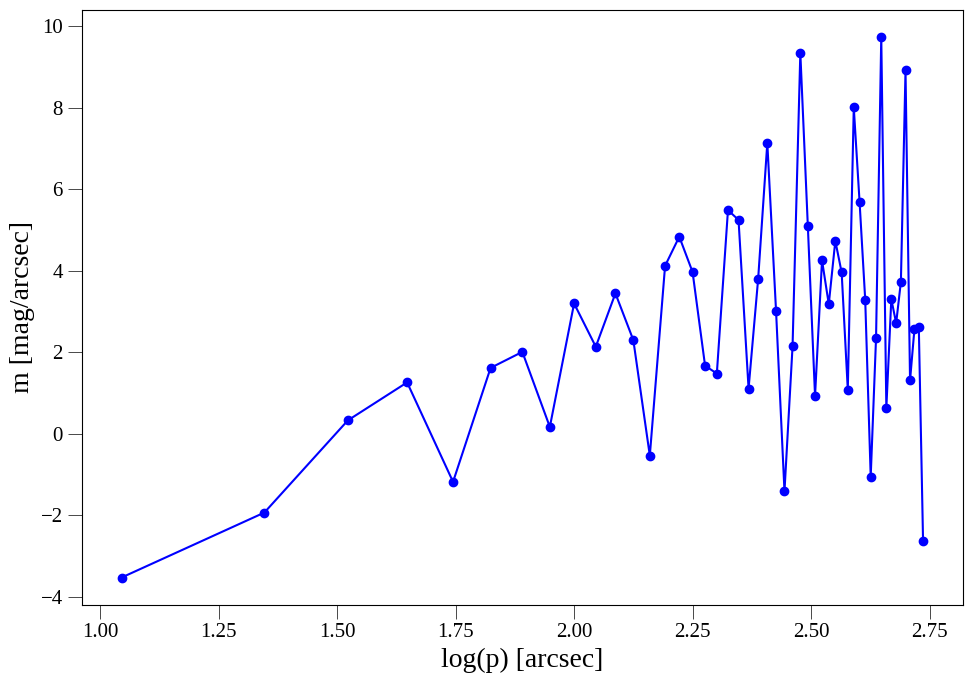

In [214]:
# Calculating the gradient of m 
m = np.gradient(surface_brightness, radii)

fig, ax = plt.subplots(figsize=(10, 7))

ax.set_xlabel('log(p) [arcsec]')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel(r'm [mag/arcsec]')
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
plt.tight_layout()  

ax.scatter(radii, m, color='blue')
ax.plot(radii, m, color='blue')

# ax.legend(loc='lower left', fontsize=15)

plt.savefig('images/grad.png')

plt.show()

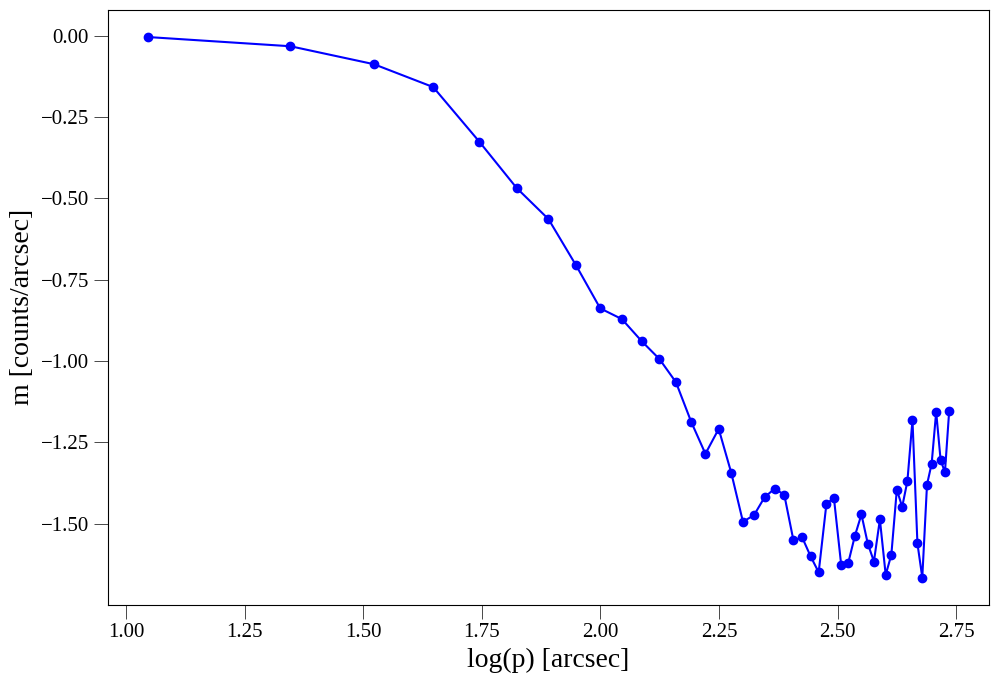

In [215]:
# Calculating the gradient of m in counts
m_counts = np.gradient(surface_brightness_counts, radii)

fig, ax = plt.subplots(figsize=(10, 7))

ax.set_xlabel('log(p) [arcsec]')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel(r'm [counts/arcsec]')
ax.yaxis.label.set_fontsize(20)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=15)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=15)
plt.tight_layout()  

ax.scatter(radii, m_counts, color='blue')
ax.plot(radii, m_counts, color='blue')

# ax.legend(loc='lower left', fontsize=15)

plt.savefig('images/grad_counts.png')

plt.show()